## Imports

In [16]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

## Load and process data

In [17]:
# Load data into DataFrame
df = pd.read_csv('/content/heart.csv')

# Display the first few rows of the dataframe
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [18]:
# Convert categorical variables into dummy/indicator variables
categorical_vars = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
df = pd.get_dummies(df, columns=categorical_vars, drop_first=True)

# Normalize/standardize numerical values
numerical_vars = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
scaler = StandardScaler()
df[numerical_vars] = scaler.fit_transform(df[numerical_vars])

# Display the preprocessed dataframe
df.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,-1.433140,0.410909,0.825070,0,1.382928,-0.832432,0,True,True,False,False,True,False,False,False,True
1,-0.478484,1.491752,-0.171961,0,0.754157,0.105664,1,False,False,True,False,True,False,False,True,False
2,-1.751359,-0.129513,0.770188,0,-1.525138,-0.832432,0,True,True,False,False,False,True,False,False,True
3,-0.584556,0.302825,0.139040,0,-1.132156,0.574711,1,False,False,False,False,True,False,True,True,False
4,0.051881,0.951331,-0.034755,0,-0.581981,-0.832432,0,True,False,True,False,True,False,False,False,True


## Split Data into Testing and training

In [19]:
# Split the dataset into train and test sets
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verify shapes of the datasets
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

Training set shape: (734, 15)
Testing set shape: (184, 15)


## Model Definitions

In [20]:
# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)

# Support Vector Machine
svm_model = SVC(kernel='linear', probability=True, random_state=42)

# GRU Model definition function
def create_gru_model(input_shape):
    model = Sequential([
        GRU(32, input_shape=input_shape, return_sequences=True),
        GRU(16),
        Dense(2, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

## Model Setup and Training

In [21]:
# Model training and predictions
rf_model.fit(X_train, y_train)
dt_model.fit(X_train, y_train)
svm_model.fit(X_train, y_train)

# Reshape input data and convert to categorical for GRU
X_train_gru = X_train.values[..., np.newaxis].astype('float32')
X_test_gru = X_test.values[..., np.newaxis].astype('float32')
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

# Initialize and train GRU model
gru_model = create_gru_model((X_train.shape[1], 1))
gru_model.fit(X_train_gru, y_train_cat, epochs=10, batch_size=32, validation_data=(X_test_gru, y_test_cat))

Epoch 1/10
23/23 [==============================] - 7s 76ms/step - loss: 0.6794 - accuracy: 0.5313 - val_loss: 0.6594 - val_accuracy: 0.5815
Epoch 2/10
23/23 [==============================] - 0s 17ms/step - loss: 0.6490 - accuracy: 0.5613 - val_loss: 0.6320 - val_accuracy: 0.5978
Epoch 3/10
23/23 [==============================] - 0s 17ms/step - loss: 0.5991 - accuracy: 0.6880 - val_loss: 0.5884 - val_accuracy: 0.7500
Epoch 4/10
23/23 [==============================] - 0s 19ms/step - loss: 0.5251 - accuracy: 0.7902 - val_loss: 0.5295 - val_accuracy: 0.7554
Epoch 5/10
23/23 [==============================] - 0s 20ms/step - loss: 0.4567 - accuracy: 0.8079 - val_loss: 0.4824 - val_accuracy: 0.7935
Epoch 6/10
23/23 [==============================] - 0s 18ms/step - loss: 0.4290 - accuracy: 0.8256 - val_loss: 0.4941 - val_accuracy: 0.7880
Epoch 7/10
23/23 [==============================] - 0s 20ms/step - loss: 0.4233 - accuracy: 0.8297 - val_loss: 0.4821 - val_accuracy: 0.7989
Epoch 8/10
23

## Cross-Validation Function for Non-GRU Models

In [23]:
def cross_validate_model(model, X, y, model_name, n_splits=10):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    results = []
    accuracies = []
    for train_index, test_index in kf.split(X):
        X_train_fold, X_test_fold = X[train_index], X[test_index]
        y_train_fold, y_test_fold = y[train_index], y[test_index]

        model.fit(X_train_fold, y_train_fold)
        predictions = model.predict(X_test_fold)
        cm = confusion_matrix(y_test_fold, predictions)

        TP = cm[1, 1]
        TN = cm[0, 0]
        FP = cm[0, 1]
        FN = cm[1, 0]

        TSS = (TP / (TP + FN)) - (FP / (FP + TN))
        HSS = 2 * (TP * TN - FP * FN) / ((TP + FN) * (FN + TN) + (TP + FP) * (FP + TN))

        accuracy = accuracy_score(y_test_fold, predictions)
        accuracies.append(accuracy)

        results.append({
            'TP': TP, 'TN': TN, 'FP': FP, 'FN': FN,
            'accuracy': accuracy,
            'precision': precision_score(y_test_fold, predictions),
            'recall': recall_score(y_test_fold, predictions),
            'f1': f1_score(y_test_fold, predictions),
            'TSS': TSS,
            'HSS': HSS
        })

    plot_results(accuracies, model_name, n_splits)
    return results

## Cross-Validation function for GRU Model

In [24]:
def cross_validate_gru(X, y, n_splits=10):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold = 0
    metrics = []
    accuracies = []

    model = create_gru_model((X.shape[1], 1))
    for train_index, test_index in kf.split(X):
        X_train_fold, X_test_fold = X[train_index], X[test_index]
        y_train_fold, y_test_fold = y[train_index], y[test_index]

        y_train_fold_cat = to_categorical(y_train_fold)
        y_test_fold_cat = to_categorical(y_test_fold)
        X_train_fold_gru = X_train_fold[..., np.newaxis].astype('float32')
        X_test_fold_gru = X_test_fold[..., np.newaxis].astype('float32')

        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        model.fit(X_train_fold_gru, y_train_fold_cat, epochs=10, batch_size=32, verbose=0)

        gru_pred_fold = model.predict(X_test_fold_gru)
        gru_pred_fold = np.argmax(gru_pred_fold, axis=1)
        cm = confusion_matrix(y_test_fold, gru_pred_fold)

        TP = cm[1, 1]
        TN = cm[0, 0]
        FP = cm[0, 1]
        FN = cm[1, 0]

        TSS = (TP / (TP + FN)) - (FP / (FP + TN))
        HSS = 2 * (TP * TN - FP * FN) / ((TP + FN) * (FN + TN) + (TP + FP) * (FP + TN))

        accuracy = accuracy_score(y_test_fold, gru_pred_fold)
        accuracies.append(accuracy)

        metrics.append({
            'TP': TP, 'TN': TN, 'FP': FP, 'FN': FN,
            'accuracy': accuracy,
            'precision': precision_score(y_test_fold, gru_pred_fold),
            'recall': recall_score(y_test_fold, gru_pred_fold),
            'f1': f1_score(y_test_fold, gru_pred_fold),
            'TSS': TSS,
            'HSS': HSS
        })

        fold += 1

    plot_results(accuracies, "GRU", n_splits)
    return metrics

In [25]:
import matplotlib.pyplot as plt

def plot_results(accuracies, model_name, n_splits):
    average_accuracy = np.mean(accuracies)
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, n_splits+1), accuracies, marker='o', linestyle='-', color='b', label='Accuracy per Fold')
    plt.axhline(y=average_accuracy, color='r', linestyle='--', label=f'Average Accuracy ({average_accuracy:.2f})')
    plt.title(f'{model_name} Model Accuracy Across 10 Folds with Average Line')
    plt.xlabel('Fold Number')
    plt.ylabel('Accuracy')
    plt.xticks(range(1, n_splits+1))
    plt.legend()
    plt.grid(True)
    plt.show()

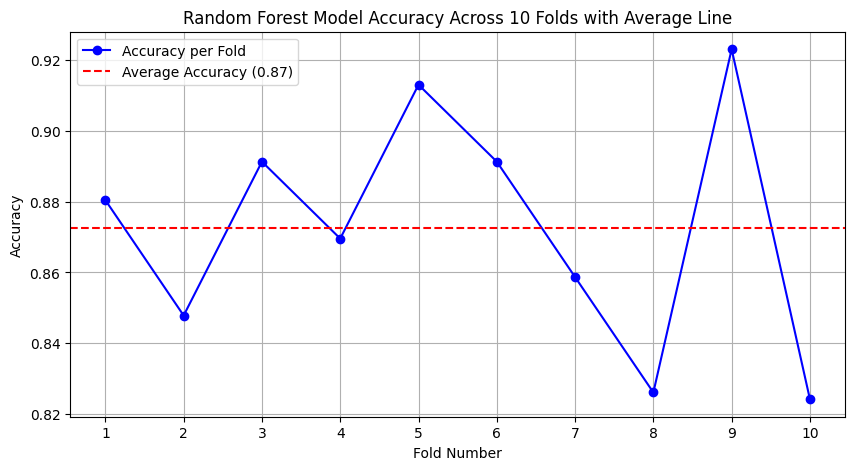

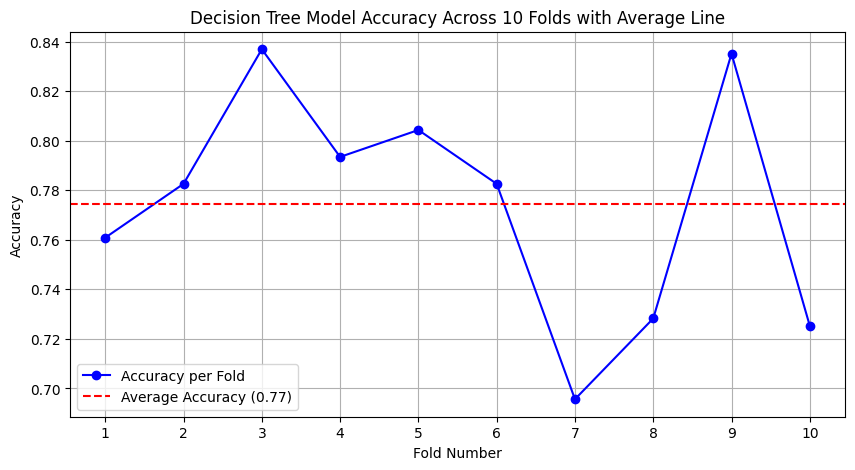

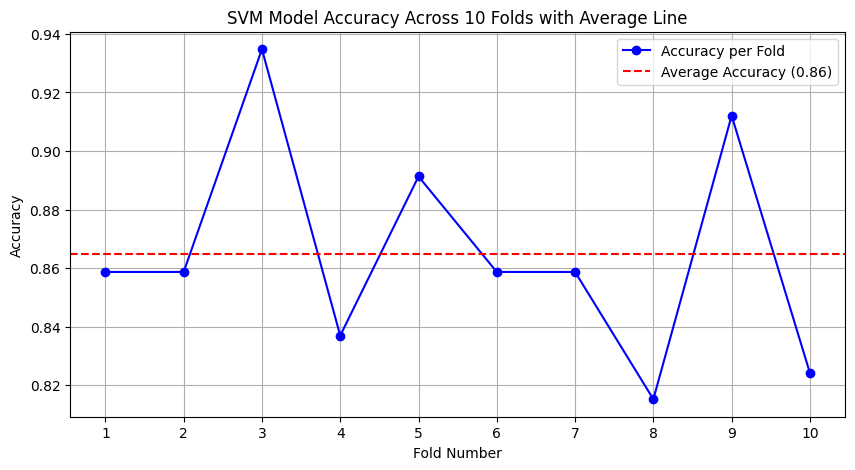

3/3 [==============================] - 1s 8ms/step


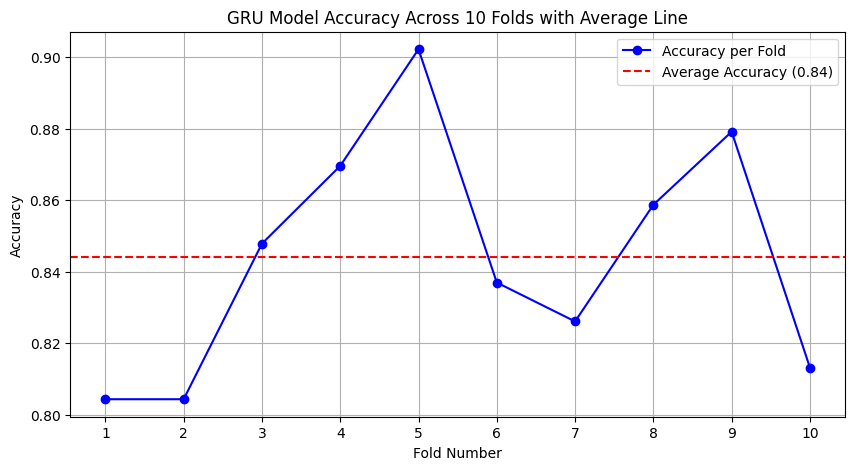

In [28]:
# Execute cross-validation for each model
rf_results = cross_validate_model(rf_model, X.values, y, "Random Forest")
dt_results = cross_validate_model(dt_model, X.values, y, "Decision Tree")
svm_results = cross_validate_model(svm_model, X.values, y, "SVM")
gru_results = cross_validate_gru(X.values, y)

In [30]:
import pandas as pd

def compile_results(rf_results, dt_results, svm_results, gru_results):
    # Convert each result list to a DataFrame
    rf_df = pd.DataFrame(rf_results).mean().to_frame('Random Forest')
    dt_df = pd.DataFrame(dt_results).mean().to_frame('Decision Tree')
    svm_df = pd.DataFrame(svm_results).mean().to_frame('SVM')
    gru_df = pd.DataFrame(gru_results).mean().to_frame('GRU')

    # Combine all DataFrames into a single DataFrame for comparison
    combined_results = pd.concat([rf_df, dt_df, svm_df, gru_df], axis=1)
    return combined_results

# Compile and print the final results
final_results = compile_results(rf_results, dt_results, svm_results, gru_results)
print(final_results)

           Random Forest  Decision Tree        SVM        GRU
TP             46.000000      41.000000  45.600000  44.600000
TN             34.100000      30.100000  33.800000  32.900000
FP              6.900000      10.900000   7.200000   8.100000
FN              4.800000       9.800000   5.200000   6.200000
accuracy        0.872551       0.774522   0.864931   0.844231
precision       0.870426       0.791916   0.864543   0.846185
recall          0.906980       0.806687   0.899699   0.880526
f1              0.886728       0.797080   0.879797   0.861564
TSS             0.740451       0.542603   0.727721   0.684836
HSS             0.740212       0.541473   0.725631   0.682877
